Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import SwitchingCoordination as sc
import numpy as np
from tqdm import tqdm

import multiprocessing
num_processors = multiprocessing.cpu_count()
print("Number of processors:", num_processors)

from importlib import reload
reload(sc)
# %load_ext autoreload
# %autoreload 2

Number of processors: 8


<module 'SwitchingCoordination' from 'c:\\Users\\sarap\\OneDrive\\Dokumente\\Studium\\8_SOSE_2023\\switching_coordination\\SwitchingCoordination.py'>

Define the parameters 

In [4]:
# simulation parameters
N = 3
ref_time = 5.0
noise_std = 0.5
avg_frequency = 0.0
write_file = False # True


# monte-carlo parameters
n_mc_reps = 5


[deprecated] Running the parameter scanning

In [8]:
# Define the array of the scanning parameter
switching_rate_arr = np.arange(start = 0, stop = 0.5, step = 0.01)

# make an empty out_data to fill in later
out_data = {}
out_data_list = []

# monte-carlo loop
for i_switching_rate, switching_rate in enumerate(tqdm(switching_rate_arr)):

    # initialize a parameter dictionary
    params = sc.InitParams(N=N,switchingRate=switching_rate,
                        refTime=ref_time,noiseStd=noise_std,
                        avgFrequency=avg_frequency, writeFile=write_file)
    
    # repeat single simulation for "n_mc_reps" times
    for mc_iter in np.arange(n_mc_reps):
        
        #perform a single simulation
        out_data_tmp = sc.SingleSimulation(params)

        # make an empty (temporary) dict to put all the data (params + output) into
        tmp_dict = {}
        # put the params into the dict
        for key, val in dict.items(params):
            tmp_dict[key] = val
        # put the time and order arrays into the dict
        tmp_dict['t'] = np.array(out_data_tmp[0]['t'])
        tmp_dict['order'] = np.array(out_data_tmp[0]['order'])
        tmp_dict["mc_iter"] = mc_iter

        # append it to the list 
        out_data_list.append(tmp_dict)

# convert it to a pd.df
out_data_df = pd.DataFrame(out_data_list)

100%|██████████| 50/50 [00:05<00:00,  9.21it/s]


New param scan, with dict

In [19]:
import pickle

# simulation parameters
N = 3
ref_time = 5.0
noise_std = 0.5
avg_frequency = 0.0
write_file = False # True

# monte-carlo parameters
n_mc_reps = 5

# make an empty out_data to fill in later
out_data = {}
out_data_list = []

param_scan_dict = {"switchingRate": {"range": np.logspace(0,1,2), "log": True},
                   "N": {"range": np.linspace(3,15,2), "log": False}}

# initialize a parameter dictionary
params = sc.InitParams(N=-1,switchingRate=-1,
                            refTime=ref_time,noiseStd=noise_std,
                            avgFrequency=avg_frequency, writeFile=write_file,showAnimation=False)

# save the param_scan_dict to a pickle file for later use
with open('paramscan_pickledict.pkl', 'wb') as handle:
    pickle.dump(param_scan_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# first parameters loop
for i_switching_rate, switching_rate in enumerate(tqdm(param_scan_dict['switchingRate']['range'])):
    params['switchingRate'] = switching_rate

    # second parameter loop
    for i_N, N in enumerate(tqdm(param_scan_dict['N']['range'])):
        params['N'] = int(N)

        # MonteCarlo Loop
        # repeat single simulation for "n_mc_reps" times
        for mc_iter in np.arange(n_mc_reps):
            
            #perform a single simulation
            out_data_tmp = sc.SingleSimulation(params)

            # make an empty (temporary) dict to put all the data (params + output) into
            tmp_dict = {}
            # put the params into the dict
            for key, val in dict.items(params):
                tmp_dict[key] = val
            # put the time and order arrays into the dict
            tmp_dict['t'] = np.array(out_data_tmp[0]['t'])
            tmp_dict['order'] = np.array(out_data_tmp[0]['order'])
            tmp_dict["mc_iter"] = mc_iter

            # append it to the list 
            out_data_list.append(tmp_dict)

# convert it to a pd.df
out_data_df = pd.DataFrame(out_data_list)

    
# add the mean order for each single simulation
out_data_df['meanOrder'] = [np.mean(x) for x in out_data_df['order']]

#save DataFrame to pickle file
out_data_df.to_pickle('paramscan_pickledata.pkl')

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:04<00:00,  2.19s/it]


In [21]:
params_to_save = params | param_scan_dict
params_to_save

{'N': {'range': array([ 3., 15.]), 'log': False},
 'couplingStrength': 1.0,
 'noiseStd': 0.5,
 'noiseAmplitude': 0.15811388300841897,
 'switchingRate': {'range': array([ 1., 10.]), 'log': True},
 'refTime': 5.0,
 'avgFrequency': 0.0,
 'stdFrequency': 0.0,
 'dt': 0.1,
 'simTime': 100.0,
 'simSteps': 1000,
 'outTime': 1.0,
 'outStep': 10,
 'writeFile': False,
 'showAnimation': False,
 'saveAnimation': False}

New param scan, with dict and multi-processing

In [5]:
# make an empty out_data to fill in later
out_data = {}
out_data_list = []

param_scan_dict = {"switchingRate": {"range": np.logspace(0,1,10), "log": True},
                   "N": {"range": np.linspace(3,15,5), "log": False}}

# initialize a parameter dictionary
params = sc.InitParams(N=-1,switchingRate=-1,
                            refTime=ref_time,noiseStd=noise_std,
                            avgFrequency=avg_frequency, writeFile=write_file,showAnimation=False)

import multiprocessing 
num_processors = multiprocessing.cpu_count()
print("Number of processors:", num_processors)

from joblib import Parallel, delayed

# Define the method to run multi_processing on MonteCarlo Rep.s
multi_processing_method = "multiprocessing" # "single_process" # "multiprocessing" # "joblib"

from importlib import reload
reload(sc)
# %load_ext autoreload
# %autoreload 2

import time

# simulation parameters
N = 3
ref_time = 5.0
noise_std = 0.5
avg_frequency = 0.0
write_file = False # True

# monte-carlo parameters
n_mc_reps = 32

# make an empty out_data to fill in later
out_data = {}
out_data_list = []

param_scan_dict = {"switchingRate": {"range": np.logspace(-3.0, 2.0, 20), "log": True},
                   "N": {"range": np.linspace(3,15,5), "log": False}}

# initialize a parameter dictionary
params = sc.InitParams(N=-1,switchingRate=-1,
                            refTime=ref_time,noiseStd=noise_std,
                            avgFrequency=avg_frequency, writeFile=write_file,showAnimation=False)

start = time.perf_counter()

# first parameters loop
for i_switching_rate, switching_rate in enumerate(tqdm(param_scan_dict['switchingRate']['range'])):
    params['switchingRate'] = switching_rate

    # second parameter loop
    for i_N, N in enumerate(tqdm(param_scan_dict['N']['range'])):
        params['N'] = int(N)

        ## # Normal for loop with single processor
        if multi_processing_method=="single_process":
            for mc_iter in np.arange(n_mc_reps):
            
        #     #perform a single simulation
                out_data_tmp = sc.SingleSimulation(params)
                # make an empty (temporary) dict to put all the data (params + output) into
                tmp_dict = {}
                # put the params into the dict
                for key, val in dict.items(params):
                    tmp_dict[key] = val
                # put the time and order arrays into the dict
                tmp_dict['t'] = np.array(out_data_tmp[0]['t'])
                tmp_dict['order'] = np.array(out_data_tmp[0]['order'])
                # tmp_dict["mc_iter"] = mc_iter

                # append it to the list 
                out_data_list.append(tmp_dict)

        
        # # parallel processing using "multiprocessing" 
        elif multi_processing_method=="multiprocessing":
            with multiprocessing.Pool(processes=num_processors) as pool:
                results = pool.map(sc.SingleSimulation, [params] * n_mc_reps)

                for out_data_tmp in results:
                # out_data_tmp = results
                    tmp_dict = {}
            #         # put the params into the dict
                    for key, val in dict.items(params):
                        tmp_dict[key] = val
                    # put the time and order arrays into the dict
                    tmp_dict['t'] = np.array(out_data_tmp[0]['t'])
                    tmp_dict['order'] = np.array(out_data_tmp[0]['order'])
                    # tmp_dict["mc_iter"] = mc_iter

                    # append it to the list 
                    out_data_list.append(tmp_dict)
            

        ## # parallel processing using "joblib"
        elif multi_processing_method=="joblib":
            results = Parallel(n_jobs=num_processors)(delayed(sc.SingleSimulation)(params) for _ in range(n_mc_reps))
            for out_data_tmp in results:
                tmp_dict = {}
        #         # put the params into the dict
                for key, val in dict.items(params):
                    tmp_dict[key] = val
                # put the time and order arrays into the dict
                tmp_dict['t'] = np.array(out_data_tmp[0]['t'])
                tmp_dict['order'] = np.array(out_data_tmp[0]['order'])
                # tmp_dict["mc_iter"] = mc_iter

                # append it to the list 
                out_data_list.append(tmp_dict)
    

finish = time.perf_counter()

print(f'Finished in {round(finish-start, 2)} second(s)')

# convert it to a pd.df
out_data_df = pd.DataFrame(out_data_list)

# add the mean order for each single simulation
out_data_df['meanOrder'] = [np.mean(x) for x in out_data_df['order']]

# calculate the average order over repetitions
avg_order =  np.empty(shape=(len(param_scan_dict['N']['range']), len(param_scan_dict['switchingRate']['range'])))
for i_N, N in enumerate(param_scan_dict['N']['range']):
    for i_switching_rate, switching_rate in enumerate(param_scan_dict['switchingRate']['range']):
        out_data_tmp = out_data_df.loc[out_data_df['switchingRate'] == param_scan_dict['switchingRate']['range'][i_switching_rate]]
        out_data_tmp = out_data_tmp.loc[out_data_tmp['N'] == param_scan_dict['N']['range'][i_N]]
        avg_order_tmp = np.mean(out_data_tmp['meanOrder'][:])
        avg_order[i_N, i_switching_rate] = avg_order_tmp

Number of processors: 8


100%|██████████| 20/20 [13:40<00:00, 41.02s/it]


Finished in 820.37 second(s)


In [ ]:
# type(out_data_df)
out_data_df.loc[0]

N                                                                   3
couplingStrength                                                  1.0
noiseStd                                                          0.5
noiseAmplitude                                               0.158114
switchingRate                                                     0.0
refTime                                                           5.0
avgFrequency                                                      0.0
stdFrequency                                                      0.0
dt                                                                0.1
simTime                                                         100.0
simSteps                                                         1000
outTime                                                           1.0
outStep                                                            10
writeFile                                                       False
t                   

Plot a single run data

Text(0.2, 0.9, 'Finished in 820.37 second(s), mean order: 0.9670467435886435')

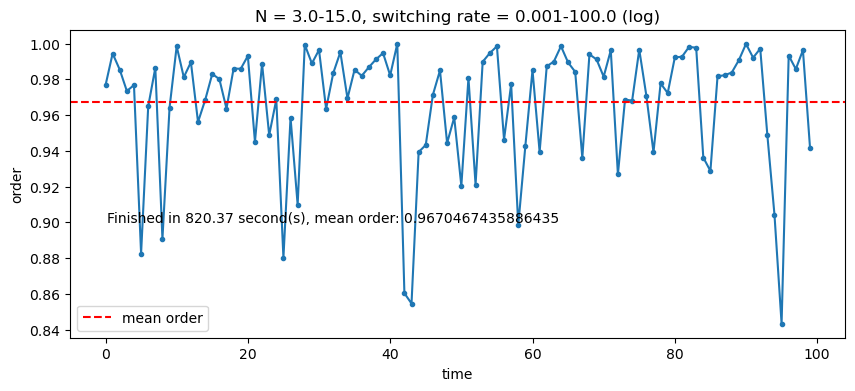

In [8]:
#plot order parameter versus time
N_0 = param_scan_dict['N']['range'][0]
N_end = param_scan_dict['N']['range'][-1]
rate_0 = param_scan_dict['switchingRate']['range'][0]
rate_end = param_scan_dict['switchingRate']['range'][-1]
mean_order = out_data_df['meanOrder'][0]

plt.figure(figsize=(10,4))
plt.title(f'N = {N_0}-{N_end}, switching rate = {rate_0}-{rate_end} (log)')
plt.plot(out_data_df.loc[0]['t'],(out_data_df.loc[0]['order']),'.-')
plt.axhline(out_data_df['meanOrder'][0], linestyle='--', color='r', label='mean order')
plt.xlabel('time')
plt.ylabel('order')
plt.legend()
plt.text(0.2,0.9,f'Finished in {round(finish-start, 2)} second(s), mean order: {mean_order}')

Calculate the average order of the monte-carlo simulations

In [6]:
param_scan_dict = {"switchingRate": {"range": np.logspace(-3.0, 2.0, 2), "log": True},
                   "N": {"range": np.linspace(3,15,2), "log": False}}
out_data_df = pd.read_pickle('paramscan_pickledata.pkl')

# calculate the mean of the average order over monte-carlo reps.
avg_order_over_reps =  np.empty(shape=(len(param_scan_dict['N']['range']), len(param_scan_dict['switchingRate']['range'])))
for i_N, N in enumerate(param_scan_dict['N']['range']):
    for i_switching_rate, switching_rate in enumerate(param_scan_dict['switchingRate']['range']):
        out_data_tmp = out_data_df.loc[out_data_df['switchingRate'] == param_scan_dict['switchingRate']['range'][i_switching_rate]]
        out_data_tmp = out_data_tmp.loc[out_data_tmp['N'] == param_scan_dict['N']['range'][i_N]]
        avg_order_tmp = np.mean(out_data_tmp['meanOrder'][:])
        avg_order_over_reps[i_N, i_switching_rate] = avg_order_tmp

Plot the average vs scanning parameter

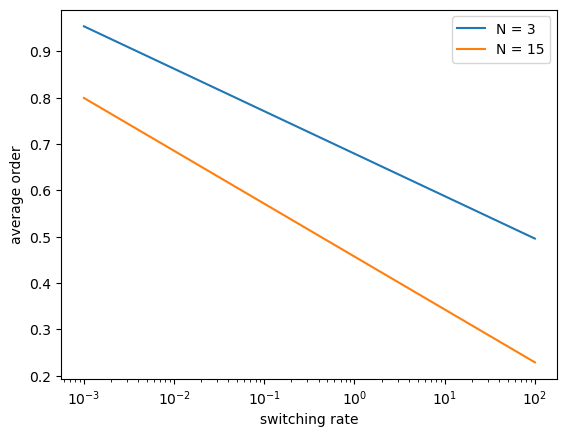

In [8]:
for i_N, N in enumerate(param_scan_dict['N']['range']):
    plt.semilogx(param_scan_dict['switchingRate']['range'], avg_order_over_reps[i_N][:], label=f'N = {int(N)}')
plt.xlabel("switching rate")
plt.ylabel("average order")
plt.legend()

In [17]:
param_scan_dict = {"switchingRate": {"range": np.logspace(-3.0, 2.0, 2), "log": True},
                   "N": {"range": np.linspace(3,15,2), "log": False}}
out_data_df = pd.read_pickle('paramscan_pickledata.pkl')
#param_scan_dict.to_pickle('paramscan_pickledict.pkl')

import pickle

# Store data (serialize)
with open('paramscan_pickledict.pkl', 'wb') as handle:
    pickle.dump(param_scan_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

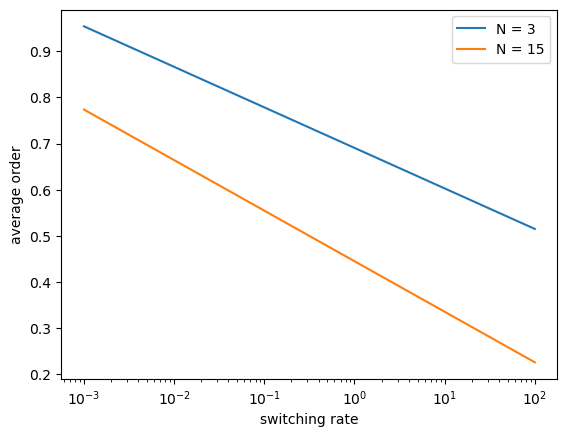

In [22]:
# Load data (deserialize)
with open('scan_32nMC_switchRate_params.pkl', 'rb') as handle:
    param_scan_dict = pickle.load(handle)

with open('scan_32nMC_switchRate_data.pkl', 'rb') as handle:
    out_data_df = pickle.load(handle)

# calculate the mean of the average order over monte-carlo reps.
avg_order_over_reps =  np.empty(shape=(len(param_scan_dict['N']['range']), len(param_scan_dict['switchingRate']['range'])))
for i_N, N in enumerate(param_scan_dict['N']['range']):
    for i_switching_rate, switching_rate in enumerate(param_scan_dict['switchingRate']['range']):
        out_data_tmp = out_data_df.loc[out_data_df['switchingRate'] == param_scan_dict['switchingRate']['range'][i_switching_rate]]
        out_data_tmp = out_data_tmp.loc[out_data_tmp['N'] == param_scan_dict['N']['range'][i_N]]
        avg_order_tmp = np.mean(out_data_tmp['meanOrder'][:])
        avg_order_over_reps[i_N, i_switching_rate] = avg_order_tmp

for i_N, N in enumerate(param_scan_dict['N']['range']):
    plt.semilogx(param_scan_dict['switchingRate']['range'], avg_order_over_reps[i_N][:], label=f'N = {int(N)}')
plt.xlabel("switching rate")
plt.ylabel("average order")
plt.legend()
